In [22]:
# 1. Load và chuẩn bị dữ liệu
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Multiply, Permute, Flatten, RepeatVector
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [23]:
# Đọc dữ liệu gốc
data = pd.read_csv('./stock_data/BTC_2010-2011.csv')

# Chuyển đổi cột 'Date' sang datetime
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Xử lý dữ liệu: không break theo ngày
X = scaled_data[:, :-1]  # Tất cả các cột trừ cột dự đoán
y = scaled_data[:, -1]   # Cột cuối cùng làm mục tiêu

# Kiểm tra kích thước
X = np.array(X)
y = np.array(y)

print("Shape of data:", data.shape)
print("Shape of scaled_data:", scaled_data.shape)
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

data.head()

Shape of data: (34105, 6)
Shape of scaled_data: (34105, 6)
Shape of X: (34105, 5)
Shape of y: (34105,)


,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2024-10-21 00:00:00+00:00,69009.367188,69009.367188,69009.367188,69009.367188,69009.367188,0.0
2024-10-21 00:01:00+00:00,69002.984375,69002.984375,69002.984375,69002.984375,69002.984375,1761280.0
2024-10-21 00:02:00+00:00,68993.679688,68993.679688,68993.679688,68993.679688,68993.679688,0.0
2024-10-21 00:03:00+00:00,68999.046875,68999.046875,68999.046875,68999.046875,68999.046875,3409920.0
2024-10-21 00:04:00+00:00,68973.656250,68973.656250,68973.656250,68973.656250,68973.656250,12740608.0


In [24]:
# 2. Xây dựng mô hình LSTM với Attention
def attention_block(inputs):
    a = Dense(1, activation='tanh')(inputs)
    a = Flatten()(a)
    a = tf.keras.activations.softmax(a)
    a = RepeatVector(tf.keras.backend.int_shape(inputs)[2])(a)  # Sử dụng K.int_shape để đảm bảo kích thước chính xác
    a = Permute([2, 1])(a)
    output = Multiply()([inputs, a])
    return output

# Input layer
inputs = Input(shape=(X.shape[1], 1))  # Dữ liệu có 1 feature/time-step

# Reshape dữ liệu để phù hợp với LSTM
reshaped_inputs = np.expand_dims(X, axis=-1)  # Định dạng cho LSTM: (samples, timesteps, features)

# LSTM layers
lstm_out = LSTM(128, return_sequences=True)(inputs)
lstm_out = Dropout(0.2)(lstm_out)

# Attention layer
attention_output = attention_block(lstm_out)

# Fully connected layers
flattened = Flatten()(attention_output)
dense_out = Dense(64, activation='relu')(flattened)
dense_out = Dropout(0.2)(dense_out)
output = Dense(1)(dense_out)

# Compile model
model = Model(inputs, output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print(model.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 5, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 5, 128)    │     66,560 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 5, 128)    │          0 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 5, 1)      │        129 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 5)         │          0 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_3 (Softmax) │ (None, 5)         │          0 │ flatten_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_3     │ (None, 128, 5)    │          0 │ softmax_3[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_3 (Permute) │ (None, 5, 128)    │          0 │ repeat_vector_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 5, 128)    │          0 │ dropout_8[0][0],  │
│ (Multiply)          │                   │            │ permute_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_9 (Flatten) │ (None, 640)       │          0 │ multiply_3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │     41,024 │ flatten_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 64)        │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │         65 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 107,778 (421.01 KB)

 Trainable params: 107,778 (421.01 KB)

 Non-trainable params: 0 (0.00 B)

None


In [28]:
# 3. Chia dữ liệu thành tập train và test
X_train, X_test, y_train, y_test = train_test_split(reshaped_inputs, y, test_size=0.2, random_state=42)

# 4. Huấn luyện mô hình
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, verbose=1)

# 5. Dự đoán
predictions_test = model.predict(X_test)

# Tính sai số trên tập test
mse_test = mean_squared_error(y_test, predictions_test)
mae_test = mean_absolute_error(y_test, predictions_test)
print(f"MSE trên tập test: {mse_test}, MAE trên tập test: {mae_test}")


Epoch 1/100
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 3.9841e-05 - mae: 0.0024 - val_loss: 1.9294e-04 - val_mae: 0.0012
Epoch 2/100
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 3.2178e-06 - mae: 8.8783e-04 - val_loss: 1.9297e-04 - val_mae: 0.0013
Epoch 3/100
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 3.1158e-06 - mae: 9.0160e-04 - val_loss: 1.9290e-04 - val_mae: 0.0012
Epoch 4/100
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 2.9608e-06 - mae: 8.6275e-04 - val_loss: 1.9303e-04 - val_mae: 0.0014
Epoch 5/100
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 3.1448e-06 - mae: 9.1019e-04 - val_loss: 1.9299e-04 - val_mae: 9.6590e-04
Epoch 6/100
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 3.0822e-06 - mae: 8.6692e-04 - val_loss: 1.9352e-04 - val_mae: 9.1924e-04
Epoch 7/100
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 2.9448e-06 - mae: 8.7224e-04 - val_loss: 1.9306e-04 - val_mae: 9.4342e-04
Epoch 8/100
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss

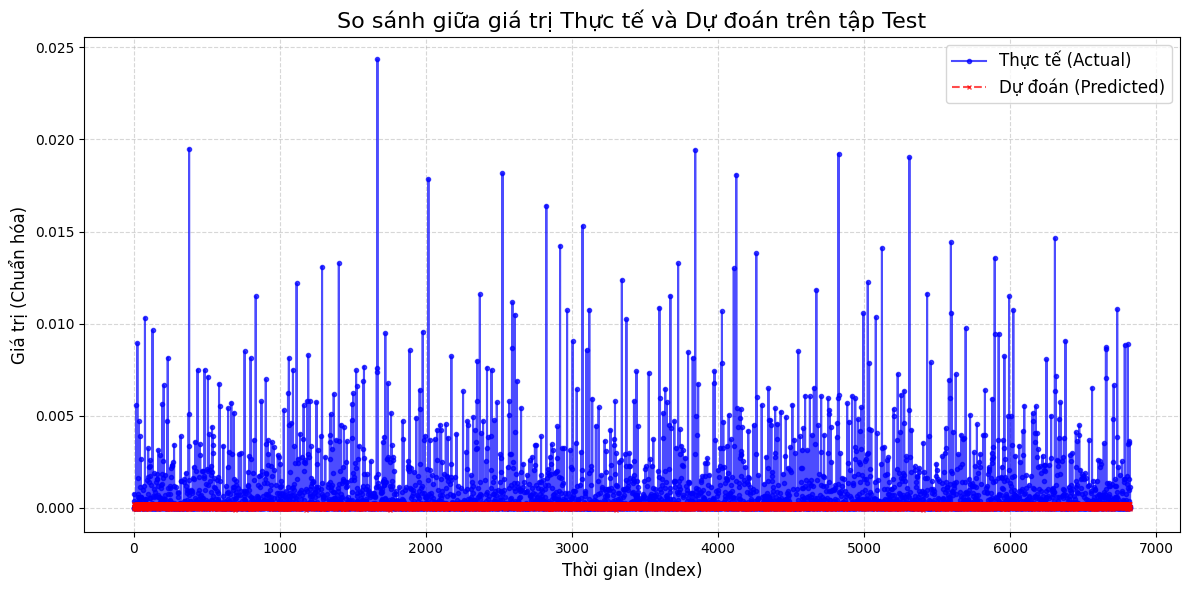

In [29]:
# 6. Vẽ biểu đồ so sánh giá trị dự đoán và giá trị thực tế
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Thực tế (Actual)", color='blue', linestyle='-', marker='o', markersize=3, alpha=0.7)
plt.plot(predictions_test, label="Dự đoán (Predicted)", color='red', linestyle='--', marker='x', markersize=3, alpha=0.7)
plt.title("So sánh giữa giá trị Thực tế và Dự đoán trên tập Test", fontsize=16)
plt.xlabel("Thời gian (Index)", fontsize=12)
plt.ylabel("Giá trị (Chuẩn hóa)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()